# David Coy Jupyter Notebook for Project 1
### Begin by importing all potentiall necessary modules into python and the google API key for GMAPS

In [2]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pdb
import gmaps, gmaps.geojson_geometries
from urllib.request import urlopen
import json
import requests
import difflib
import sys
import datetime
import google, googlesearch
from scipy.stats import linregress

# Google developer API key
sys.path.append('../')
from config import gkey

# Configure gmaps
gmaps.configure(api_key=gkey)

#### Import the already downloaded database in group directory for the previously compiled plane crash data

###### Data: https://www.kaggle.com/chadmunger/plane-crashes-1908-2019

###### Begin by removing filtering for fatal accidents

In [ ]:
data_df = pd.read_csv(os.path.join('./DCC_Data/', 'FinalDatasetAirplaneCrashes'))

In [ ]:
df = data_df[(data_df["Fatalities"] >= 0 ) & (abs(data_df["Latitude"]) >= 0 )]
df = df.replace(np.nan, '', regex=True)

#Make sure some of the columns are actually numeric for later processing
df['Aboard'] = pd.to_numeric(df['Aboard'])
df['Fatalities'] = pd.to_numeric(df['Fatalities'])

#Create a new column for the percent that survided the crash:
df['Percent Survived'] = df.apply(lambda x: 100 if x['Fatalities'] ==0 else x['Fatalities']/x['Aboard']*100, axis =1)
df.head()

In [ ]:
#function to return country using latitude and longitude
def nearest(row):#https://stackoverflow.com/questions/20169467/how-to-convert-from-longitude-and-latitude-to-country-or-city
    lat=row['Latitude']
    lon=row['Longitude']
    params = {
        "key": gkey,
        "radius": "50000",
        "location" : str(row["Latitude"]) + "," + str(row["Longitude"])
         }
    base_url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"
    response = requests.get(base_url, params=params).json()
    #pdb.set_trace()  
    try:
        country = response['results'][0]['vicinity'] 
    except:
        country = ''
    #print(requests.get(base_url, params=params).url)
    #print(json.dumps(response, indent=4, sort_keys=True))
    return(country) 

### Introduce a new data set also from Kaggle for historic GDP for different countries as a function of year.
#### https://www.kaggle.com/jonscheaffer/worldwide-gdp-history-19602016?select=gdp_data.csv

In [ ]:
planecrash_df = pd.read_csv("./DCC_Data/df_with_country_with nearest.csv")
gdp_df = pd.read_csv("./DCC_Data/gdp_data.csv", engine='python')

planecrash_df['Year'] = planecrash_df.apply(lambda x: x['Date'][0:4]     ,axis=1)
gdp_df['Year'] = gdp_df['Year'].astype(str)


planecrash_df['GDP'] = 0 #Create and fill new column
for i, row in planecrash_df.iterrows():
    try:
        planecrash_df.loc[i,'GDP'] = gdp_df[(gdp_df["Country"]==row["Country"])  & (gdp_df["Year"]==row["Year"])  ].values[0][-1]

    except:
        planecrash_df.loc[i,'GDP'] = 0

#### Filter the data some more to remove useless rows and data
#### Remove any entry that clearly states that this was a "Military" flights or there is simply no information on the "Route" as these will onnly skew what we are really intersted in

In [ ]:
planecrash_df = planecrash_df.dropna(subset=['Operator','Route'])
planecrash_df = planecrash_df[~planecrash_df['Operator'].str.contains('Military',case=False)]
planecrash_df = planecrash_df[planecrash_df['Route'].str.contains(' - ',case=False)]

#### There is a confusing issue that the departure location is burried with other information on the "Route" column which complicates things and and attempt is made to make sense of it

In [ ]:
#Get the departure location name and put it in a new column
planecrash_df['Departure'] = planecrash_df.apply(lambda x: x['Route'].split(' - ')[0], axis=1)

In [ ]:
# Function to convert a string for city to a guess on its latitude longitude using google using findplacefromtext
def city_to_lat_lng(row):#https://stackoverflow.com/questions/20169467/how-to-convert-from-longitude-and-latitude-to-country-or-city
    params = {
        "key": gkey,
        "input": row['Departure'],
        "inputtype":"textquery"
         }
    base_url = "https://maps.googleapis.com/maps/api/place/findplacefromtext/json?"
    response = requests.get(base_url, params=params).json()
    #print(requests.get(base_url, params=params).url) 
    try:
        place_id = response['candidates'][0]['place_id']
    except:
        place_id = ''
        
    params = {
        "key": gkey,
        "place_id": place_id
         }
    
    base_url = "https://maps.googleapis.com/maps/api/place/details/json?"
    response = requests.get(base_url, params=params).json()
    #print(requests.get(base_url, params=params).url)
    try:
        lat = response['result']['geometry']['location']['lat']
        lng = response['result']['geometry']['location']['lng']
        country = response['result']['address_components'][3]['long_name']
    except:
        lat = ''
        lng = ''
        country = ''
    return(str(lat) + ',' + str(lng)) 

In [ ]:
# Function to convert a string for city to a guess on its Country using google using findplacefromtext
def city_to_country(row):#https://stackoverflow.com/questions/20169467/how-to-convert-from-longitude-and-latitude-to-country-or-city
    params = {
        "key": gkey,
        "input": row['Departure'],
        "inputtype":"textquery"
         }
    base_url = "https://maps.googleapis.com/maps/api/place/findplacefromtext/json?"
    response = requests.get(base_url, params=params).json()
    #print(requests.get(base_url, params=params).url) 
    try:
        place_id = response['candidates'][0]['place_id']
        #https://developers.google.com/places/web-service/details 
    except:
        place_id = ''
        
    params = {
        "key": gkey,
        "place_id": place_id
         }
    
    base_url = "https://maps.googleapis.com/maps/api/place/details/json?"
    response = requests.get(base_url, params=params).json()
    #print(requests.get(base_url, params=params).url)
    try:
        country = response['result']['address_components'][3]['long_name']
    except:
        country = ''
    return(country) 

In [ ]:
#Create new columns for later ploting
######################################
# WARNING! This take hours to run!!!!!
######################################

planecrash_df['Departure Lat,Lng'] = 0 # Create new empty column
planecrash_df[['Departure Lat,Lng']] = planecrash_df.apply( city_to_lat_lng, axis=1)
planecrash_df['Departure Country'] = 0 # Create new empty column
planecrash_df[['Departure Country']] = planecrash_df.apply( city_to_country, axis=1)

In [ ]:
# After spending hours doing google searches from above commands, save immedietly but incommenting
# Otherwise just skip and read the already completed file

#planecrash_df.to_csv("./DCC_Data/df_final_unfiltered.csv")
df = pd.read_csv("./DCC_Data/df_final_unfiltered.csv")

In [ ]:
#Do some basic filtering after importing csv, to remove junk rows that are missing information
df = df.dropna(subset = ['Departure Country', 'Departure Lat,Lng'])
df = df[df['Departure Lat,Lng'].apply(lambda x: len(x)) >3]
df = df[df['Departure Country'].apply(lambda x: len(x)) >2]
df = df.drop(['Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1'],axis=1)

#Again save file!  
df.to_csv("./DCC_Data/df_final_filtered.csv", index=False)
df = pd.read_csv("./DCC_Data/df_final_filtered.csv")
df.head()

#### Reload GDP Information

In [ ]:
#df = pd.read_csv("./DCC_Data/df_final_filtered.csv")
gdp_df = pd.read_csv("./DCC_Data/gdp_data.csv")

In [ ]:
gdp_df.loc[:,'Year'] = gdp_df["Year"].astype(int);
df.loc[:,'Year'] = df["Year"].astype(int);

In [ ]:
df['GDP'] = 0 #Create and fill new column
for i, row in df.iterrows():
    try:
        df.loc[i,'GDP'] = gdp_df[(gdp_df["Country"]==row["Departure Country"])  & (gdp_df["Year"]==row["Year"])  ].values[0][-1]

    except:
        df.loc[i,'GDP'] = 0
df.tail(50);

In [3]:
#df.to_csv("./DCC_Data/df_final_filtered_GDP.csv", index=False)
df = pd.read_csv("./DCC_Data/df_final_filtered_GDP.csv")

In [56]:
def google_plot(df, idk=False):
    text_list=[]
    #Also instead of \n you must use html's <br/>
    for index, row in df.iterrows():
        text_list.append('Information: <br/>' + 
                         "Date: " + str(row['Date']) + "<br/>" + 
                         "Time: " + str(row['Time']) + "<br/>" +
                         "Operator: " + str(row['Operator']) + "<br/>" +
                         "Flight #: " + str(row['Flight #']) + "<br/>" +
                         "Route: " + str(row['Route']) + "<br/>" +
                         "AC Type: " + str(row['AC Type']) + "<br/>" +
                         "Registration: " + str(row['Registration']) + "<br/>" +
                         "cn/ln: " + str(row['cn/ln']) + "<br/>" +
                         "Aboard: " + str(row['Aboard']) + "<br/>" +
                         "Aboard Passengers: " + str(row['Aboard Passengers']) + "<br/>" +
                         "Aboard Crew: " + str(row['Aboard Crew']) + "<br/>" +
                         "Fatalities: " + str(row['Fatalities']) + "<br/>" +
                         "Fatalities Passengers: " + str(row['Fatalities Passengers']) + "<br/>" +
                         "Fatalities Crew: " + str(row['Fatalities Crew']) + "<br/>" +
                         "Ground: " + str(row['Ground']) + "<br/>" +
                         "Summary: " + str(row['Summary']) + "<br/>" +
                         "Location: " + str(row['Location']) + "<br/>" +
                         "Latitude: " + str(row['Latitude']) + "<br/>" +
                         "Latitude: " + str(row['Latitude']) + "<br/>" +
                         "geometry: " + str(row['geometry']) + "<br/>"
                        )
    
    
    Lines=[]
    for i, row in df.iterrows():
        #pdb.set_trace()
        lat, lng = row["Departure Lat,Lng"].replace('(', '').replace(')', '').split(",")
        #print(lat)
        start_lat =float(lat)
        start_lng =float(lng)
        crash_lat = row['Latitude']
        crash_lng = row['Longitude']
        line = gmaps.Line((start_lat, start_lng), (crash_lat, crash_lng),
                          stroke_weight=3.0)
        Lines.append(line)
    
    rating = df["Fatalities"]
    locations = df[["Latitude", "Longitude"]]

    # Plot Heatmap
    fig2 = gmaps.figure(display_toolbar=True,
                        display_errors=True,
                        zoom_level=3,
                        center=(33.7490, -84.3880) #Atlanta Georgia
                       )
    figure_layout2 = {
        'width': '2000px',
        'height': '2000px',
        'border': '1px solid black',
        'padding': '1px'
    }
    gmaps.figure(layout=figure_layout2)

    # Create heat layer
    heat_layer = gmaps.heatmap_layer(locations.values, 
                                     weights=rating, 
                                     dissipating=True, 
                                     max_intensity=df['Fatalities'].max()/1,
                                     point_radius=15,
                                     opacity=0.95)
    # Add layer
    fig2.add_layer(heat_layer)

    if text=True:
        marker_layer = gmaps.marker_layer(locations,info_box_content=text_list)
    
    # Display figure
    #fig2.add_layer(marker_layer)

    # Features to draw on the map
    drawing = gmaps.drawing_layer(features=Lines)
    fig2.add_layer(drawing)
    
    countries_geojson = gmaps.geojson_geometries.load_geometry('countries')
    
    return fig2

SyntaxError: invalid syntax (<ipython-input-56-35ab519528f0>, line 69)

In [ ]:
df_USA = df[df['Departure Country'] == 'United States']
df_USA = df_USA[df_USA['GDP'] != 0]#Remove all rows with GDP=0 because they are kinda useless
df_USA.tail(5)

In [ ]:
google_plot(df_USA[  df_USA['Year'].isin(range(1960,1969+1,1))   ])

In [ ]:
google_plot(df_USA[  df_USA['Year'].isin(range(1970,1979+1,1))   ])

In [ ]:
google_plot(df_USA[  df_USA['Year'].isin(range(1980,1989+1,1))   ])

In [ ]:
google_plot(df_USA[  df_USA['Year'].isin(range(1990,1999+1,1))   ])

In [ ]:
google_plot(df_USA[  df_USA['Year'].isin(range(2000,2009+1,1))   ])

In [ ]:
google_plot(df_USA[  df_USA['Year'].isin(range(2010,2020+1,1))   ])

In [61]:
df = df[df['Departure Country'].isin(['United States','Canada','Mexico'])]
google_plot(df[  df['Year'].isin(range(1960,2020+1,1))],   )

Figure(layout=FigureLayout(height='420px'))

In [ ]:
pd.set_option('display.max_columns', 500)


df = df.dropna(subset=['GDP'])
df_new = df[  (df['Year'].isin(range(1990,2000+1,1))) ]
df_new = df_new[ (df_new['GDP'] > 0)]

fig1, ax1 = plt.subplots()
ax1.set_title('Data')
x=df_new['GDP']
y=df_new['Fatalities']

ax1.set_xlabel(x.name + ' [$]')
ax1.set_ylabel(y.name)
ax1.set_xlim(df_new['GDP'].min(), df_new['GDP'].max())
ax1.set_xscale('symlog')
plt.scatter(x,y)

(slope, intercept, rvalue, pvalue, stderr) = linregress(x, y)
regress_values = x * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(x,regress_values,"r-")
plt.annotate(line_eq,(0,50),fontsize=15,color="red")

plt.show

Text(0.05, 0.95, '$y=-0.000\\;x+0.000$\n$R^2 = 0.012$')

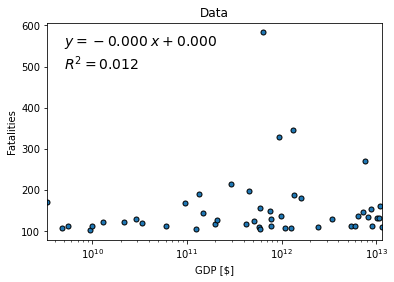

In [33]:
from sklearn.metrics import r2_score

pd.set_option('display.max_columns', 500)
df = df.dropna(subset=['GDP'])
df_new = df[  (df['Year'].isin(range(1960,2000+1,1))) ]
df_new = df_new[ (df_new['GDP'] > 0)]
df_new = df_new[ (df_new['Fatalities'] > 100)]

fig1, ax1 = plt.subplots()
ax1.set_title('Data')
x=df_new['GDP']
y=df_new['Fatalities']

ax1.set_xlabel(x.name + ' [$]')
ax1.set_ylabel(y.name)
ax1.set_xlim(df_new['GDP'].min(), df_new['GDP'].max())
#ax1.set_xscale('symlog')
ax1.set_xscale('log')

plt.plot(x,y,".", ms=10, mec="k")
z = np.polyfit(x, y, 2)
y_hat = np.poly1d(z)(x)
#https://stackoverflow.com/questions/41635448/how-can-i-draw-scatter-trend-line-on-matplot-python-pandas/41635626
#plt.plot(x, y_hat, "r--", lw=1)
text = f"$y={z[0]:0.3f}\;x{z[1]:+0.3f}$\n$R^2 = {r2_score(y,y_hat):0.3f}$"
plt.gca().text(0.05, 0.95, text,transform=plt.gca().transAxes,
     fontsize=14, verticalalignment='top')

In [30]:
df_new

,Date,Time,Operator,Flight #,Route,AC Type,Registration,cn/ln,Aboard,Aboard Passengers,Aboard Crew,Fatalities,Fatalities Passengers,Fatalities Crew,Ground,Summary,Location,Latitude,Longitude,geometry,Percent Survived,Country,Year,GDP,Departure,"Departure Lat,Lng",Departure Country
1635,1990-01-15,08:30,SANSA,032,San Jose - Palmar Sur,CASA 212 Aviocar 200,TI-SAB,163,23.0,20.0,3.0,23.0,20.0,3.0,0.0,"Crashed about 4,500 feet up on 7,250 ft. Pico ...","Pico Blanco, Costa Rica",9.872902,-84.148812,POINT (9.872901800000001 -84.14881240000003),100.000000,Costa Rica,1990,9.308206e+12,San Jose,"37.3382082,-121.8863286",United States
1637,1990-01-25,NaN,Airfast Services,NaN,Ujung Pandang - Selaparang,Hawker Siddeley HS-748-2A,PK-OBW,1567,19.0,16.0,3.0,19.0,16.0,3.0,0.0,Crashed into Mt. Ringani after being diverted ...,"Mt Rijani, Lombok Island, Indonesia",-8.595916,116.117507,POINT (-8.595916000000001 116.117507),100.000000,Indonesia,1990,3.527580e+11,Ujung Pandang,"-5.147665099999999,119.4327314",Indonesia
1638,1990-01-25,21:34,AVIANCA,052,Medellin - New York City,Boeing B-707-321B,HK 2016,19276/592,158.0,149.0,9.0,73.0,65.0,8.0,0.0,The aircraft was put in a series of extended h...,"Cove Neck, New York",40.882321,-73.505956,POINT (40.88232070000001 -73.5059562),46.202532,United States,1990,1.567799e+11,Medellin,"6.2476376,-75.56581530000001",Colombia
1639,1990-01-26,NaN,MIAT - Mongolian Airlines,NaN,Ulan Bator - Uliastaj,Antonov AN-26V,\t BNMAU-10208,\t 57310208,30.0,25.0,5.0,30.0,25.0,5.0,0.0,The Antonov crashed after failing to find the ...,"Zavkhan, Mongolia",48.293428,96.447996,POINT (48.2934284 96.4479958),100.000000,Mongolia,1990,3.187217e+09,Ulan Bator,"47.88639879999999,106.9057439",Mongolia
1644,1990-02-14,13:03,Indian Airlines,605,Bombay - Bangalore,Airbus A320-231,VT-EPN,079,146.0,139.0,7.0,92.0,87.0,5.0,0.0,"On final approach, the aircraft descended belo...","Bangalore, India",12.979120,77.591300,POINT (12.9791198 77.59129969999999),63.013699,India,1990,5.410499e+11,Bombay,"19.0759837,72.8776559",India
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1923,2000-07-27,10:31,Royal Nepal Airlines,NaN,Bajhang - Dhangadhi,de Havilland Canada DHC-6 Twin Otter 300,9N-ABP,654,25.0,22.0,3.0,25.0,22.0,3.0,0.0,The aircraft crashed into the Churia mountain ...,"Jatra, Nepal",27.713609,85.310202,POINT (27.7136089 85.3102021),100.000000,Nepal,2000,1.143674e+10,Bajhang,"29.776669,81.2518833",Nepal
1924,2000-08-02,08:45,Air taxi - Lider Air Taxi,NaN,Cubatao - Navegantes,Sikorsky S-76,PT-HRD,NaN,6.0,5.0,1.0,6.0,5.0,1.0,0.0,The helicopter exploded and crashed from a hei...,"Cubatao, Brazil",-23.885798,-46.424187,POINT (-23.8857982 -46.4241869),100.000000,Brazil,2000,1.607729e+12,Cubatao,"-23.8916151,-46.4244141",Brazil
1925,2000-08-09,08:00,Patuxent Airways / Private,NaN,"Lakehurst, NY - Patuxent River, MD",Piper Navajo PA-31/ Piper Seminole PA-44,N27944 / N2225G,7952056/79951271,11.0,8.0,3.0,11.0,8.0,3.0,0.0,The two aircraft collided over a central New J...,"Burlington Township, New Jersey",40.072587,-74.887008,POINT (40.072587 -74.8870075583862),100.000000,United States,2000,1.296826e+13,"Lakehurst, NY","40.014561,-74.3112574",United States
1927,2000-10-31,11:27,Aca-Ancargo,NaN,Saurimo - Luanda,Antonov AN-26,D2-FDI,27312009,44.0,39.0,5.0,44.0,39.0,5.0,0.0,The aircraft exploded in midair 20 minutes aft...,"Monaquimbundo, Angola",-37.804678,-72.702036,POINT (-37.804678 -72.70203599999998),100.000000,Chile,2000,4.263883e+10,Saurimo,"-9.661217299999999,20.3904598",Angola


In [ ]:

df_corr = df_new.corr()
df_corr.unstack().sort_values()

### Alternative method for collecting GDP data besides Kaggle

In [ ]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/Users/davidcoy/Downloads/My First Project-d821d4ac1a16.json"
print(os.environ['GOOGLE_APPLICATION_CREDENTIALS']) 

In [ ]:
import bq_helper
from bq_helper import BigQueryHelper #https://www.kaggle.com/sohier/introduction-to-the-bq-helper-package

In [ ]:
#https://www.kaggle.com/jessicali9530/how-to-query-world-development-indicators-data
wdi = bq_helper.BigQueryHelper(active_project="patents-public-data",
                                   dataset_name="worldbank_wdi")

In [ ]:
# View table names under the worldbank_wdi data table
bq_assistant = BigQueryHelper("patents-public-data", "worldbank_wdi")
bq_assistant.list_tables()

In [ ]:
# View the first three rows of the wdi_2016 data table
df = bq_assistant.head("wdi_2016", num_rows=100)
df

In [ ]:
query1 = """
SELECT
  country_name, indicator_value
FROM
  `patents-public-data.worldbank_wdi.wdi_2016`
ORDER BY 
  indicator_value DESC
LIMIT
  20;
        """
response1 = wdi.query_to_pandas_safe(query1)
response1.head(20)